# BERT Fine-Tuning Sentence Classification
Copyright 2020 Denis Rothman. The text cells were taken out and replaced by titles of each cell withing the cell. The titles of the cells refer to the titles of the sections of the book. The descriptions of the cells have been rewritten for educational purposes.

Contributer: George Mihaila

[Reference Notebook by Chris McCormick and Nick Ryan](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)

[Reference Article by Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

In [1]:
#@title Activating the GPU
# Main menu->Runtime->Change Runtime Type
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#@title Installing the Hugging Face PyTorch Interface for Bert
# !pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers

     |████████████████████████████████| 2.3MB 7.7MB/s 
     |████████████████████████████████| 3.3MB 40.1MB/s 
     |████████████████████████████████| 901kB 53.6MB/s 


In [3]:
#@title Importing the modules
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
#@title Specifying CUDA as the device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

@article{warstadt2018neural,
    title={Neural Network Acceptability Judgments},
    author={Warstadt, Alex and Singh, Amanpreet and Bowman, Samuel R},
    journal={arXiv preprint arXiv:1805.12471},
    year={2018}
}


In [5]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("/content/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [6]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7264,sks13,1,NaN,i wonder whether mary will win .
1314,r-67,1,NaN,make yourself comfortable .
7307,sks13,0,*,it was some beer or it took place some beer .
2679,l-93,1,NaN,the books slid across the table .
1273,r-67,1,NaN,"irma washed the dishes , and sally dried , and..."
7544,sks13,1,NaN,john heard their criticism of themselves .
6498,d_98,1,NaN,john did n't see anything .
2473,l-93,1,NaN,sarah sang a ballad .
5153,ks08,1,NaN,being lovely to look at has its advantages .
2868,l-93,1,NaN,that chisel carved the statue .


In [7]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [8]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [9]:
#@title Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [10]:
#@title Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [11]:
#@title Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [12]:
#@title Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [13]:
#@title Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [14]:
#@title Bert Configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [15]:
#@title Loading the Hugging Face Bert Uncased Base Model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [17]:
#@title The Hyperparemeters for the Training Loop 
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [18]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.49674606267594695


Epoch:  25%|██▌       | 1/4 [02:41<08:03, 161.10s/it]

Validation Accuracy: 0.8086419753086419
Train loss: 0.2959949417480295


Epoch:  50%|█████     | 2/4 [05:33<05:29, 164.63s/it]

Validation Accuracy: 0.82445987654321
Train loss: 0.1706758276308226


Epoch:  75%|███████▌  | 3/4 [08:27<02:47, 167.23s/it]

Validation Accuracy: 0.8368055555555556
Train loss: 0.10636583962612998


Epoch: 100%|██████████| 4/4 [11:20<00:00, 170.12s/it]

Validation Accuracy: 0.8263888888888888


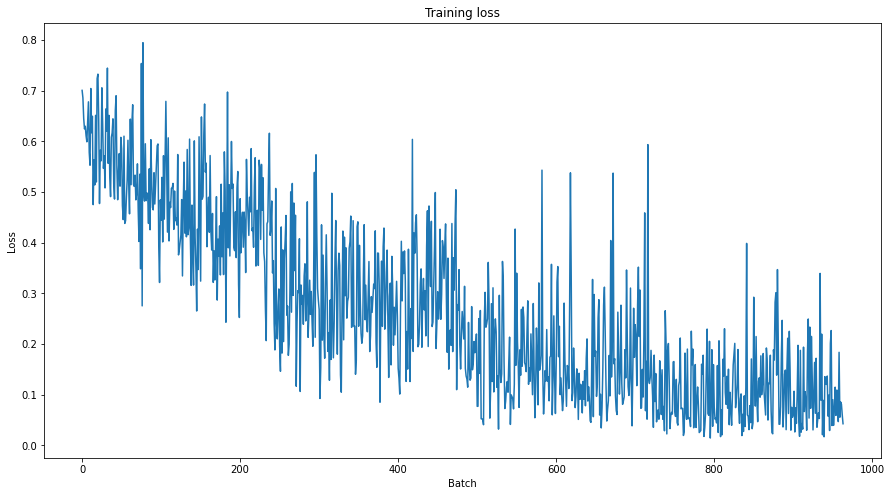

In [20]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [21]:
#@title Predicting and Evaluating Using the Hold-out Dataset 
df = pd.read_csv("/content/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [22]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [23]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [24]:
#@title Score of Individual Batches
matthews_set

[0.049286405809014416,
 -0.050964719143762556,
 0.4732058754737091,
 0.11365840154561273,
 0.32328707534629597,
 0.7410010097502685,
 0.4526019054848144,
 0.47519096331149147,
 0.9165151389911681,
 0.6952687917708212,
 0.9229582069908973,
 0.647150228929434,
 0.7562449037944323,
 0.7141684885491869,
 0.38461538461538464,
 0.6476427756840265,
 0.0]

In [25]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5401499402520816